In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
%matplotlib inline

In [2]:
# Get the collection of n(=1)-sentence snippets with the word 'love'
love_snippets = pd.read_pickle('./data/processed/love_snippets')

In [3]:
love_snippets.n_love_sents.sum()

3160

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [4]:
love_snippets.loc[[132, 2382]]

,transcript,url,sentences,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,57,12,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,109,15,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [5]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

In [6]:
# Topic modeling
# Vectorize
cv1 = CountVectorizer(stop_words='english',binary=True)
cv_doc_word = cv1.fit_transform(love_snippets.love)
# Dimension Reduction
cv_lsa=[]
cv_doc_topic=[]
for i in range(2,6):
    cv_lsa.append(TruncatedSVD(i))
    cv_doc_topic.append(cv_lsa[i-2].fit_transform(cv_doc_word))
    print(int(i),'topics variance ratios:',cv_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.02128322 0.01730593]
3 topics variance ratios: [0.02128322 0.01730685 0.01293253]
4 topics variance ratios: [0.02128322 0.01730665 0.01293576 0.01073805]
5 topics variance ratios: [0.02128322 0.01730535 0.0129353  0.01072979 0.00945658]


# The 2-Topic Result

In [7]:
display_topics(cv_lsa[0], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, just, person, think, feel, people, say, want, got, like, don, time, life, years


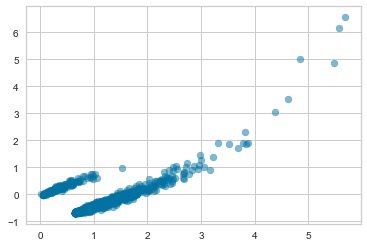

In [8]:
plt.scatter(cv_doc_topic[0][:,0],cv_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

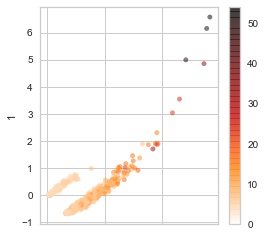

In [9]:
df=pd.DataFrame(cv_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents.astype({'n_love_sents':'int32'})+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

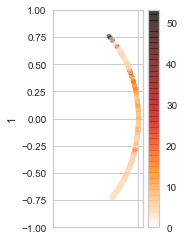

In [10]:
df = pd.DataFrame(normalize(cv_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

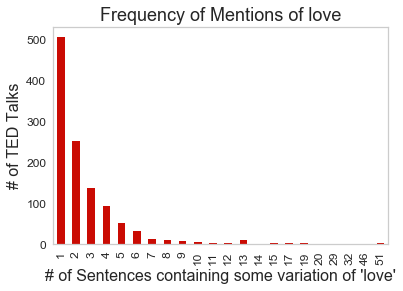

In [11]:
freq=pd.DataFrame(love_snippets.n_love_sents.value_counts()).sort_index()
ax = freq.plot.bar(title="Frequency of Mentions of love",\
                  legend=False, fontsize=12, color='r')
ax.title.set_size(18)
ax.set_xlabel("# of Sentences containing some variation of 'love'", fontsize=16)
ax.set_ylabel("# of TED Talks", fontsize=16)
ax.grid(False)
fig = ax.get_figure()
fig.savefig('./reports/figures/LoveMentionsInTEDTalks.svg',\
            format='svg', dpi=1200, transparent=True);

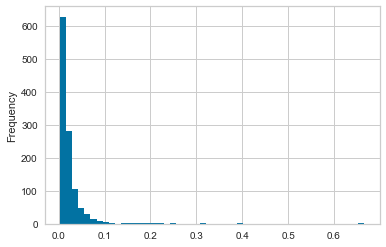

In [12]:
pct = love_snippets.n_love_sents/love_snippets.sentences
pct.plot.hist(bins=50);

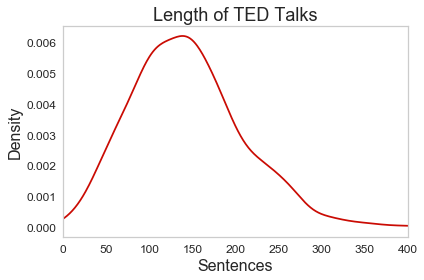

In [13]:
ax = love_snippets.sentences.plot.density(title="Length of TED Talks",\
                  legend=False, fontsize=12, color='r')
ax.title.set_size(18)
ax.set_xlabel("Sentences", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
ax.set_xlim(0,400)
ax.grid(False)
fig = ax.get_figure()
plt.tight_layout()
fig.savefig('./reports/figures/TEDTalkLengthDensityPlot.svg',\
            format='svg', dpi=1200, transparent=True);

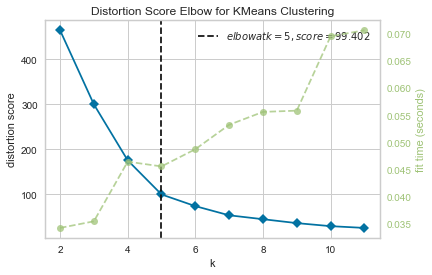

In [14]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(cv_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [15]:
visualizer.elbow_value_

5

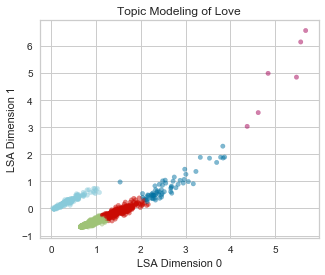

In [16]:
df=pd.DataFrame(cv_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [17]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [ 1.48143655 -0.13265827]
g [ 0.87313438 -0.545665  ]
b [2.58769911 0.80610511]
c [0.3845791  0.25739006]
m [5.09312952 4.85678056]


In [18]:
love_snippets['cluster']= km.labels_
love_snippets.groupby(['cluster']).mean()

,sentences,n_love_sents
cluster,,
0,153.593960,3.761745
1,142.375209,1.725293
2,164.692308,8.830769
3,129.437500,1.227273
4,171.666667,36.500000


In [19]:
love_snippets[love_snippets['cluster']==2].love

5       You gave them love, joy, were there to comfort...
74      Art, in the Platonic sense, is truth; it's bea...
147     And I just love learning and I'm incredibly in...
205     I would love to talk about stuff that I'm inte...
212     The first idea I'd like to suggest is that we ...
                              ...                        
2350    Joel responded better than anyone expected to ...
2356    You have a lot of love. You've had three life-...
2367    I sell dreams, and I peddle love to millions o...
2369    "(Laughter)I fell in love with Paul as I watch...
2436    The conversational nature of reality is the fa...
Name: love, Length: 65, dtype: object

Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [20]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,cv_doc_topic[0]).T).head()

,0,1,2,3,4
0,0.172707,0.562574,1.622927,1.073207,6.322866
1,0.439997,0.295711,1.887778,0.959000,6.570636
2,0.851470,0.116411,2.299757,0.960124,6.968182
3,0.109700,0.635026,1.556621,1.142436,6.269067
4,2.064551,2.794141,0.617069,2.805606,4.158245


Show the snippets from the 4 (euclidean distance) closest documents:

In [21]:
doc_topic = cv_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 1.48143655 -0.13265827] color= r
1137 : [ 1.47691784 -0.14157508] From our love of Colorado to our love of sushi, there wasn't much we didn't agree on. We also discovered that we share a deep love of this country and feel a responsibility to be politically active. CQ: I may hate camping, but I love politics. (Laughter)Seeing Lauran's sons at the march and holding signs took it to a new level for me, and not in a good way, because I know these boys, I love these boys, and I didn't feel they were old enough to understand what the march stood for. "But we love them. Love you.
238 : [ 1.4884272  -0.12496356] And it's not just going to happen because a spirit of love wafts us down. It's in his book "The Four Loves. " He said that he distinguished between erotic love, when two people gaze, spellbound, into each other's eyes. We don't have to fall in love with each other, but we can become friends.
192 : [ 1.49324715 -0.11880552] Now that title, that phrase, comes from 

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

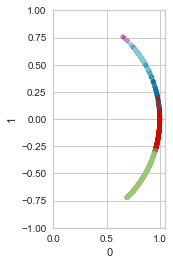

In [22]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [23]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 1.48143655 -0.13265827] color= r
510 : [ 1.50154664 -0.1356557 ] And so many of the calls went like this, "Dr. Brown, we loved your TED talk. It wasn't until a man looked at me after a book signing, and said, "I love what say about shame, I'm curious why you didn't mention men. "
513 : [ 1.50154664 -0.1356557 ] And so many of the calls went like this, "Dr. Brown, we loved your TED talk. It wasn't until a man looked at me after a book signing, and said, "I love what say about shame, I'm curious why you didn't mention men. "
1048 : [ 1.33312106 -0.11661832] I was a PhD student at Harvard, and I loved to travel. I had just gotten engaged to marry the love of my life. On the other end of the spectrum, some were so sick they had to live in complete darkness, unable to tolerate the sound of a human voice or the touch of a loved one.
817 : [ 1.62727008 -0.15149527] Can you imagine our country embracing young black men, seeing them as part of our future, giving them that

Now clustering on the 

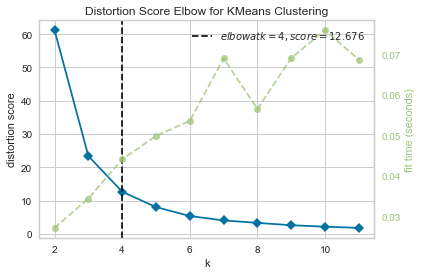

In [24]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

<Figure size 432x288 with 0 Axes>

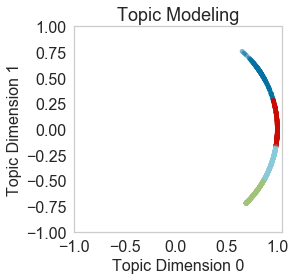

In [25]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

fig = plt.figure() 
ax = df.plot.scatter(x=0,y=1,figsize=(4,4), c=col, alpha = 0.5,title='Topic Modeling',\
                     fontsize=16);
ax.title.set_size(18)
ax.set_xlabel("Topic Dimension 0", fontsize=16)
ax.set_ylabel("Topic Dimension 1", fontsize=16)
ax.grid(False)
fig = ax.get_figure()
plt.tight_layout()
plt.axis([-1,1.05,-1,1]);
plt.savefig("reports/figures/CV_binary-lsa_2topic.svg",\
            format='svg', dpi=1200, transparent=True)

In [26]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.99180887 0.01534315] color= r
917 : [0.99991189 0.0132748 ] Let's start with a question: Does my dog really love me, or does she just want a treat? Well, it's easy to see that our dog really loves us, easy to see, right, what's going on in that fuzzy little head. But why is the question always do they love us? But love is not the thing that makes us human. So we started with a question: Do they love us?
33 : [0.99991507 0.01303294] I would love to talk about the technology, and sometime, in what's past the 15 minutes, I'll be happy to talk to all the techno-geeks around here about what's in here. I love them all. And again, I say that not to attack any industry, I think — I really do — I love my airplane, and cars on highways moving 60 miles an hour are extraordinarily efficient, both from an engineering point of view, an energy consumption point of view, and a utility point of view. And we all love our cars, and I do. It's just fun, and people love to move arou

# The 3-Topic Result

In [27]:
display_topics(cv_lsa[1], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, just, person, feel, think, people, say, want, got, like, don, time, life, years

Topic  2
love, think, want, study, thinking, lot, romantic, brain, ve, know, work, little, start, partner


In [28]:
cv_doc_topic[1]

array([[ 1.33989809, -0.23099374, -0.66959585],
       [ 1.11048996, -0.37053072,  0.12426633],
       [ 0.78114597, -0.61843857,  0.19022909],
       ...,
       [ 0.74191763, -0.62491018,  0.16348513],
       [ 1.13037855, -0.57204261,  0.15309528],
       [ 0.87370683, -0.57802421,  0.04329715]])

In [29]:
from mpl_toolkits.mplot3d import Axes3D

In [30]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(cv_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

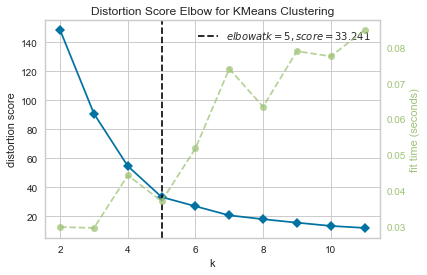

In [31]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [32]:
num_clusters = 4 #visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


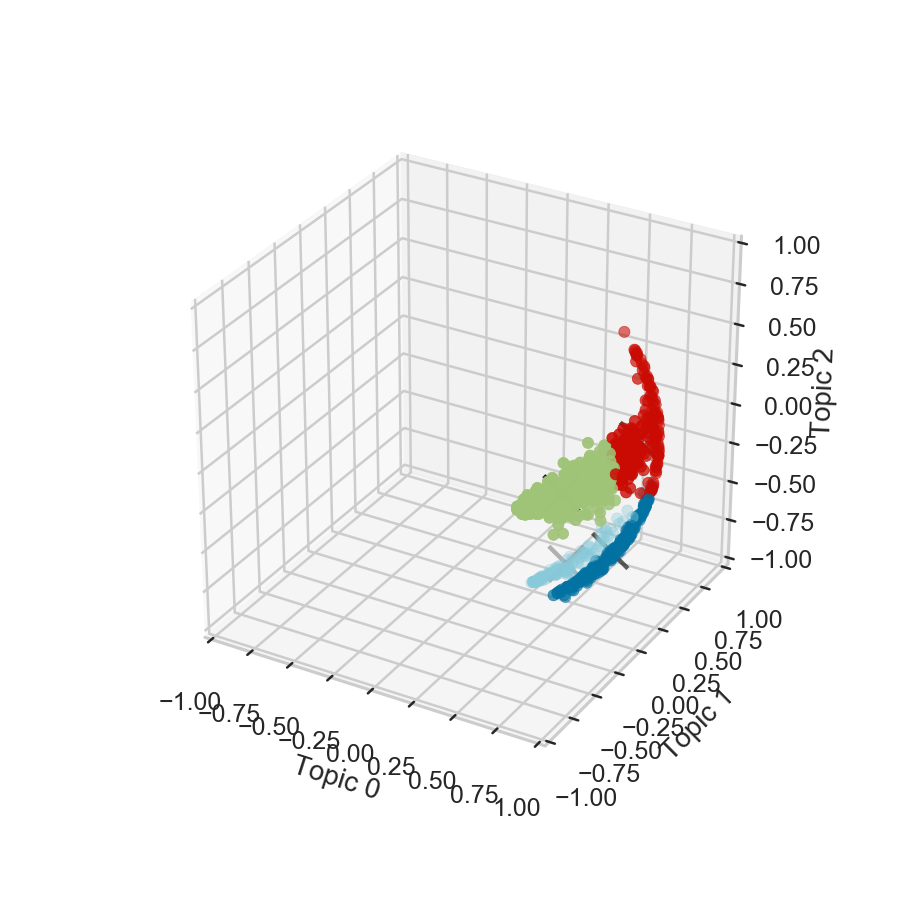

In [35]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0],df[1],df[2],c=col)
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=200,c='k')
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

So, what do the clusters mean?

In [36]:
doc_topic = cv_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.9197829  0.14869521 0.18224452] color= r
516 : [0.96360452 0.16961677 0.20663129] I love this. I'm a woman who loves getting texts who's going to tell you that too many of them can be a problem. Connecting in sips may work for gathering discrete bits of information, they may work for saying, "I'm thinking about you," or even for saying, "I love you," — I mean, look at how I felt when I got that text from my daughter — but they don't really work for learning about each other, for really coming to know and understand each other. And we're afraid, like young lovers, that too much talking might spoil the romance. An ad campaign promises that online and with avatars, you can "Finally, love your friends love your body, love your life, online and with avatars. " Let's talk about how we can use digital technology, the technology of our dreams, to make this life the life we can love.
607 : [0.9745608  0.1705903  0.14536228] Tell the Iranians we from Israel love you too. 

# The 4-Topic Result

In [7]:
display_topics(cv_lsa[2], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, laughter, really, time, ve, things, life, said

Topic  1
loved, person, just, think, feel, people, say, want, got, like, don, time, life, years

Topic  2
love, think, want, study, thinking, lot, romantic, brain, work, ve, little, single, partner, drive

Topic  3
love, loved, fell, idea, doing, times, instead, laughter, didn, great, version, make, experiences, generous


In [8]:
doc_topic = cv_doc_topic[2]
df = pd.DataFrame(normalize(cv_doc_topic[2]))

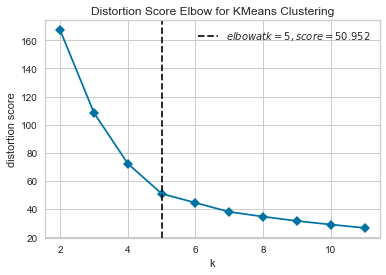

In [9]:
%matplotlib inline
fig, ax = plt.subplots()
km=KMeans()
visualizer = KElbowVisualizer(km, ax=ax, k=(2,12),metric='distortion',\
                              timings=False)  #,title='for KMeans Clustering')
visualizer.fit(df)                     # Fit the data to the visualizer
# fig.suptitle('Distortion Score Elbow', fontsize=18)
# ax.set_xlabel('k',fontsize=16)
# ax.set_ylabel('Distortion Score',fontsize=16)
visualizer.show(outpath='./reports/figures/cv_binary_lsa_4Elbow.svg',dpi=1200);                     # Finalize and render the figure

In [10]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


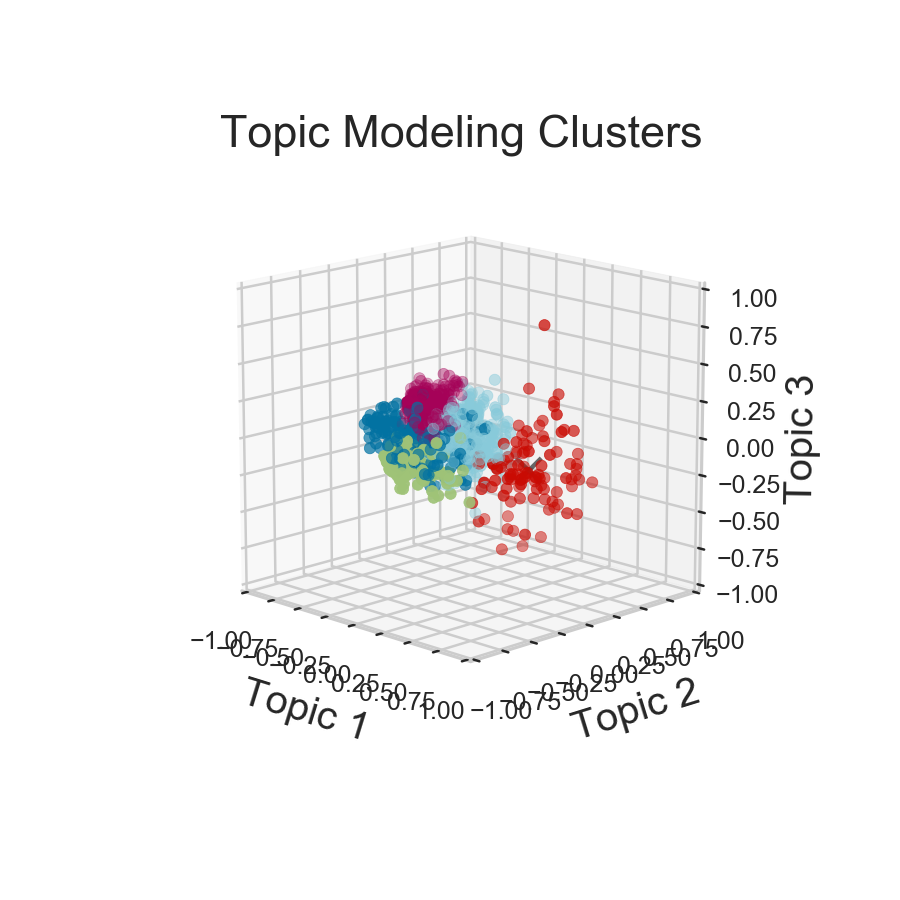

In [14]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) # .gca(projection='3d')
ax = fig.add_subplot(111, projection='3d',\
                     title="Topic Modeling Clusters")
ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=100,c='k')
ax.scatter(df[1],df[2],df[3],c=col)
ax.title.set_size(18)
# The newlines in front of the labels make it so they are better spaced
# from the axis:
# source: https://stackoverflow.com/questions/5525782/adjust-label-positioning-in-axes3d-of-matplotlib
ax.set_xlabel('\nTopic 1', fontsize=16)
ax.set_ylabel('\nTopic 2', fontsize=16)
ax.set_zlabel('\nTopic 3', fontsize=16)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.view_init(elev=15, azim=-45)
ax.dist = 12
fig.show()
fig.savefig('./reports/figures/cv_binary-lsa_4topic.svg',\
            format='svg', dpi=1200, transparent=True);

<IPython.core.display.Javascript object>


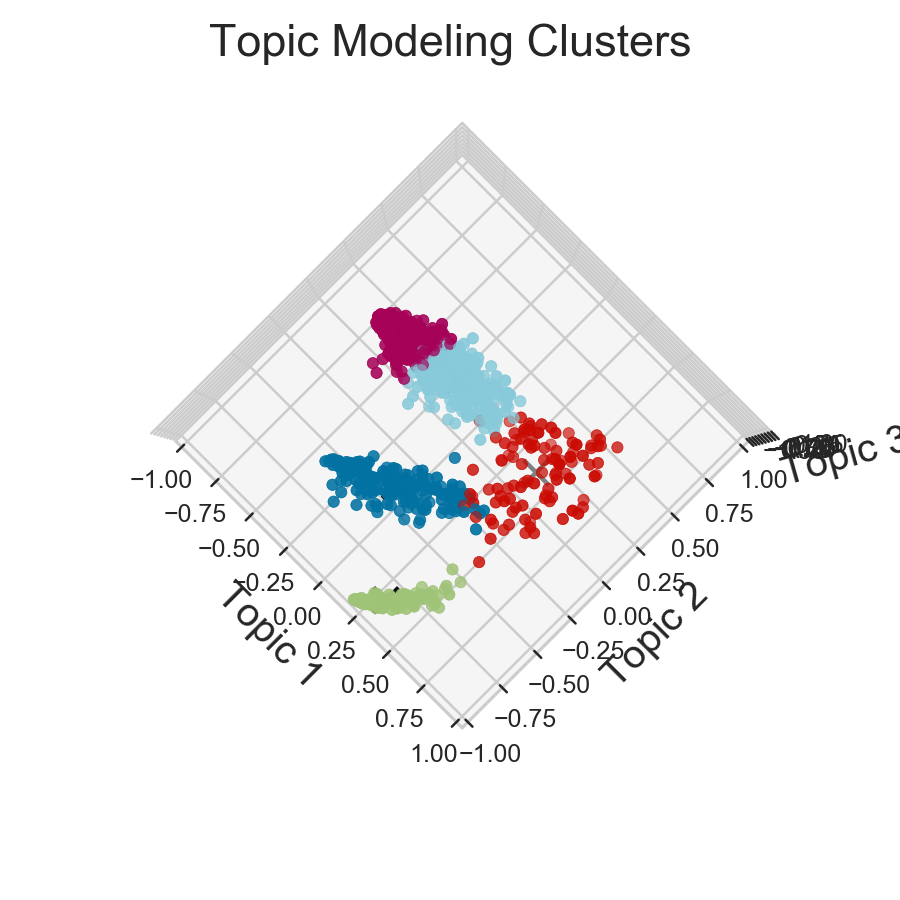

In [15]:
# Set up formatting for the movie files
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/Cellar/ffmpeg/4.2.1_2/bin/ffmpeg'
Writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='Sean Davern'),\
                                bitrate=-1, extra_args=['-vcodec','libx264'])

# Create a figure and a 3D Axes
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, title="Topic Modeling Clusters")
ax.title.set_size(18)
ax.set_xlabel('\nTopic 1', fontsize=16)
ax.set_ylabel('\nTopic 2', fontsize=16)
ax.set_zlabel('\nTopic 3', fontsize=16)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
# Create an init function and the animate functions.
# Both are explained in the tutorial:
# http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/
# Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function.
def init():
    ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=100,c='k')
    ax.scatter(df[1],df[2],df[3],c=col)
    ax.dist = 12
    return fig,

def animate(i):
    ax.view_init(elev=15+i, azim=-45)
    ax.dist = 12
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=75, interval=1, blit=True,
                               repeat=False)
# Save
anim.save('./reports/figures/cv_binary-lsa_animation.mp4',\
          writer = Writer, dpi=600)

In [ ]:
doc_topic = cv_doc_topic[2]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')